In [1]:
import sxs
import qnm
from kuibit.timeseries import TimeSeries as kuibit_ts
import sys
sys.path.append("..")
import gen_utils
import numpy as np
import BOB_utils

## 09/22

In [ ]:
def test_add_positive_numbers():
    assert add(2, 3) == 5

def test_add_negative_numbers():
    assert add(-1, -1) == -2

In [22]:
def test_kuibit(fname = 'sxs_cache/cce9/Lev5_rhOverM_BondiCce_R0472.h5', l = 2, m = 0):
    try:
        fload = sxs.rpdmb.load(fname)
    except:
        fload = sxs.rpxmb.load(fname)

    strain = gen_utils.get_kuibit_lm(fload,l,m)
    x_real = strain.real().t
    y_real = strain.real().y
    y_im = strain.imag().y

    # Load reference
    ref = np.load("trusted_outputs/kuibit_cce9_rhOverM_R0472_l2_m0.npz")
    ref_x = ref["x_real"]
    ref_y_real = ref["y_real"]
    ref_y_im = ref["y_im"]

    return strain, ref_x, ref_y_real, ref_y_im
    #     # Compare arrays
    # np.testing.assert_allclose(x_real, ref_x, rtol=1e-12, atol=1e-15)
    # np.testing.assert_allclose(y_real, ref_y_real, rtol=1e-12, atol=1e-15)
    # np.testing.assert_allclose(y_im, ref_y_im, rtol=1e-12, atol=1e-15)

In [44]:
def kuibit_lm_saver(fname = 'sxs_cache/cce9/Lev5_rhOverM_BondiCce_R0472.h5', location ="trusted_outputs/kuibit_cce9_rhOverM_R0472_l2_m0.npz",  l = 2 , m = 0):
    try:
        fload = sxs.rpdmb.load(fname)
    except:
        fload = sxs.rpxmb.load(fname)

    strain = gen_utils.get_kuibit_lm(fload,l,m)
    x_real = strain.real().t
    y_real = strain.real().y
    y_im = strain.imag().y

    np.savez(location,
    x_real=x_real,
    y_real=y_real,
    y_im=y_im
)
    return 



In [ ]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def get_kuibit_lm(w,l,m):
    index = w.index(l, m)
    w_temp = w.data[:,index]
    time = w.t
    return kuibit_ts(time,w_temp)
def get_kuibit_lm_psi4(w,l,m):
    index = w.index(l, m)
    w_temp = w[:,index].ndarray
    time = w.t
    return kuibit_ts(time,w_temp)
def get_kuibit_frequency_lm(w,l,m):
    ts = get_kuibit_lm_psi4(w,l,m)
    #returns the time derivative of np.unwrap(np.angle(w.y))
    ts_temp = ts.phase_angular_velocity()
    #want positive
    return kuibit_ts(ts_temp.t,-ts_temp.y)
def get_phase(ts):
    y = np.unwrap(np.angle(ts.y))
    #we want to make sure the phase is positive near merger so this how we check for now
    #TODO: make this better
    if(y[-1]<0):
        y = -y
    return kuibit_ts(ts.t,y)
def get_frequency(ts):
    tp = ts.time_at_maximum()
    freq = ts.phase_angular_velocity()
    if(freq.y[find_nearest_index(freq.t,tp)]<0):
        freq.y = -freq.y
    return kuibit_ts(ts.t,freq.y)
def get_r_isco(chi,M):
    #Bardeen Press Teukolskly eq 2.21
    #defined for prograde orbits
    a = chi*M
    a_M = a/M

    z1 = 1 + (((1-a_M**2)**(1./3.)) * ((1+a_M)**(1./3.) + (1-a_M)**(1./3.))) #good
    z2 = (3*(a_M**2) + z1**2)**0.5 #good
    r_isco = M * (3 + z2 - ((3-z1)*(3+z1+2*z2))**0.5) #good
    return r_isco

In [45]:
location = "trusted_outputs/kuibit_cce9_rhOverM_R0472_freq_l2_m2.npz"
try:
    fload = sxs.rpdmb.load('sxs_cache/cce9/Lev5_rMPsi4_BondiCce_R0472.h5')
except:
    fload = sxs.rpxmb.load('sxs_cache/cce9/Lev5_rMPsi4_BondiCce_R0472.h5')
strain = gen_utils.get_kuibit_frequency_lm(fload,2,2)
x_real = strain.real().t
y_real = strain.real().y
y_im = strain.imag().y

np.savez(location,
    x_real=x_real,
    y_real=y_real,
    y_im=y_im)


In [74]:

try:
    fload = sxs.rpdmb.load('sxs_cache/cce9/Lev5_rMPsi4_BondiCce_R0472.h5')
except:
    fload = sxs.rpxmb.load('sxs_cache/cce9/Lev5_rMPsi4_BondiCce_R0472.h5')
strain = gen_utils.get_kuibit_lm(fload,2,2)
# x_real = strain.real().t
# y_real = strain.real().y
# y_im = strain.imag().y

y_real

array([  0.41171014,   0.41558122,   0.41863859, ..., 378.09239897,
       378.09669697, 378.10109021])

In [75]:
ts = gen_utils.get_phase(strain)

x_real = ts.real().t
y_real = ts.real().y
y_im = ts.imag().y

location = "trusted_outputs/kuibit_cce9_rhOverM_R0472_get_phase_l2_m2.npz"
np.savez(location,
    x_real=x_real,
    y_real=y_real,
    y_im=y_im)

In [47]:
location = "trusted_outputs/kuibit_cce9_rhOverM_R0472_get_phase_l2_m2.npz"
ref = np.load(location)

In [ ]:
def get_qnm(chif,Mf,l,m,n=0,sign=1):
    #omega_qnm, all_C, ells = qnmfits.read_qnms.qnm_from_tuple((l,m,n,1),chif,M=M)
    if(sign==-1):
        grav_lmn = qnm.modes_cache(s=-2,l=l,m=-m,n=n)
        omega_qnm, A, C = grav_lmn(a=chif)#qnm package uses M = 1 so a = chi here
        omega_qnm = -np.conj(omega_qnm)
    else:
        grav_lmn = qnm.modes_cache(s=-2,l=l,m=m,n=n)
        omega_qnm, A, C = grav_lmn(a=chif)#qnm package uses M = 1 so a = chi here
    omega_qnm /= Mf #rescale to remnant black hole mass
    w_r = np.abs(omega_qnm.real)
    imag_qnm = np.abs(omega_qnm.imag)
    tau = 1./imag_qnm
    return w_r,tau

In [90]:
gen_utils.get_Omega_isco(0.9, 5.0)
gen_utils.get_qnm(0.0, 1.0, 2, 2)
gen_utils.get_qnm(0.0, 1.0, 3, 2)
gen_utils.get_qnm(0.0, 1.0, 2, 2, n = 1)
gen_utils.get_qnm(0.5, 1.0, 2, 2, sign = -1)
gen_utils.get_qnm(0.5, 1.0, 2, 2, sign = 1)
gen_utils.get_qnm(0.5, 2.0, 2, 2, sign = 1)

(0.37367168441804177, 11.24071459084527)

In [80]:
ts = gen_utils.get_frequency(strain)

x_real = ts.real().t
y_real = ts.real().y
y_im = ts.imag().y

location = "trusted_outputs/kuibit_cce9_rhOverM_R0472_get_frequency_l2_m2.npz"
np.savez(location,
    x_real=x_real,
    y_real=y_real,
    y_im=y_im)

## 09/29

In [4]:
def psi4_h5():
    fname = 'sxs_cache/cce9/Lev5_rMPsi4_BondiCce_R0472.h5'
    try:
        fload = sxs.rpdmb.load(fname)
    except:
        fload = sxs.rpxmb.load(fname)
    return fload
def psi4_ts(psi4_h5):
    ts = gen_utils.get_kuibit_lm(psi4_h5,2,2)
    return ts

In [5]:
ts_psi4 = psi4_ts(psi4_h5())
amp = np.abs(ts_psi4)

In [7]:
gen_utils.get_tp_Ap_from_spline(amp)

(5147.456847890223, 0.058162818007723834)

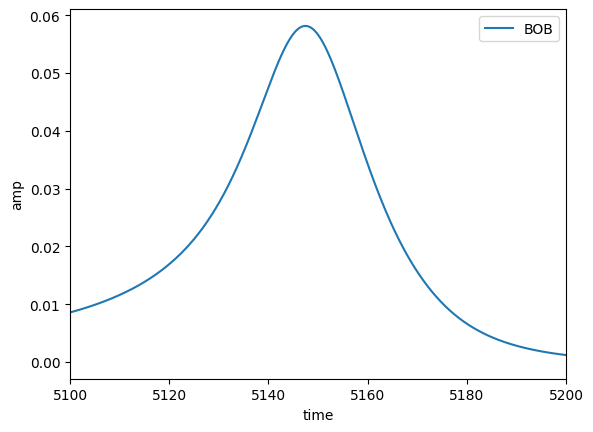

In [120]:
import matplotlib.pyplot as plt

plt.plot(ts2.t,ts2.y,label='BOB')
plt.xlim(5100,5200)
plt.xlabel('time')
plt.ylabel('amp')
plt.legend()
plt.show()

In [59]:
BOB = BOB_utils.BOB()
BOB.initialize_with_NR_psi4_data(t = ts_psi4.t, y = ts_psi4.y, mf = 0.949435238357, chif = (-1.10929877907e-08,
        3.32552069179e-09,
        0.678561988326))
BOB.what_should_BOB_create = "psi4"
BOB.optimize_Omega0_and_Phi0 = True

Destination path /home/chrosmic/.cache/qnm/data-0.4.0.tar.bz2 already exists, use overwrite=True to force an overwrite.


In [60]:
def save_bob_attributes(BOB, filename):
    """
    Save the physically important BOB parameters to a .npz file.
    """
    attrs_to_save = {
        "mf": BOB.mf,
        "chif": np.array(BOB.chif),
        "l": BOB.l,
        "m": BOB.m,
        "Ap": BOB.Ap,
        "tp": BOB.tp,
        "Omega_0": BOB.Omega_0,
        "Phi_0": BOB.Phi_0,
        "tau": BOB.tau,
        "Omega_ISCO": BOB.Omega_ISCO,
        "what_should_BOB_create": getattr(BOB, "what_should_BOB_create", None),
        "optimize_Omega0_and_Phi0": getattr(BOB, "optimize_Omega0_and_Phi0", None),
    }

    np.savez(filename, **attrs_to_save)
    print(f"[INFO] Saved BOB parameters to {filename}")

In [62]:
save_bob_attributes(BOB, "trusted_outputs/BOB_NR_CCE9_psi4.npz")

[INFO] Saved BOB parameters to trusted_outputs/BOB_NR_CCE9_psi4.npz


/home/chrosmic/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/chrosmic/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


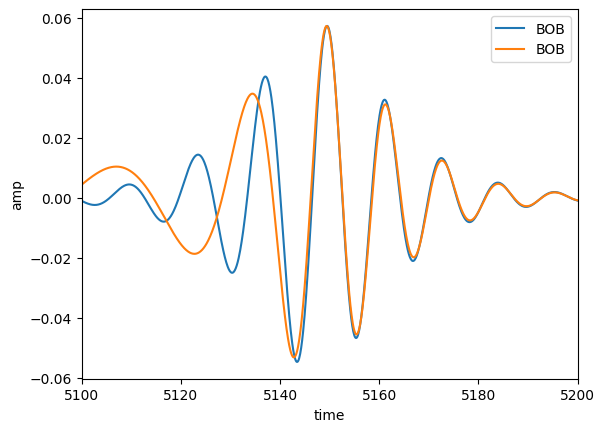

In [9]:
t_bob, y_bob = BOB.construct_BOB()
ts = BOB.psi4_data

import matplotlib.pyplot as plt
plt.plot(t_bob,y_bob,label='BOB')
plt.plot(ts.t,ts.y,label='BOB')
plt.xlim(5100,5200)
plt.xlabel('time')
plt.ylabel('amp')
plt.legend()
plt.show()

In [46]:
location = "trusted_outputs/cce9_psi4_ts.npz"
timeseries = {
    "BOB": ts_BOB,
    "SXS": ts_psi4,
}
def kuibit_ts_save(timeseries, location):
    # timeseries is an dictionary of kuibit timeseries
    # location is the relative path
    arrays_to_save = {}
    for name, ts in timeseries.items():
        # Store both time and data arrays under unique keys
        arrays_to_save[f"{name}_t"] = ts.t
        arrays_to_save[f"{name}_y"] = ts.y
    np.savez(location, **arrays_to_save)
    return 
def kuibit_ts_load(location):
    data = np.load(location)
    timeseries = {}
    for key in data.files:
        if key.endswith("_t"):
            name = key[:-2]
            t = data[f"{name}_t"]
            y = data[f"{name}_y"]
            timeseries[name] = kuibit_ts(t, y)
    return timeseries


In [66]:
ts_BOB = kuibit_ts(t_bob, y_bob)

In [67]:
ts_BOB.t

array([5072.45684789, 5072.55684789, 5072.65684789, ..., 5247.15684789,
       5247.25684789, 5247.35684789])

In [64]:
ts_BOB.t

array([5072.45684789, 5072.55684789, 5072.65684789, ..., 5247.15684789,
       5247.25684789, 5247.35684789])

In [65]:
ts_SXS.t

array([2.60200581e-02, 1.04149257e-01, 1.82278522e-01, ...,
       5.49718646e+03, 5.49726458e+03, 5.49734270e+03])

In [49]:
ts_BOB, ts_SXS = kuibit_ts_load(location)['BOB'], kuibit_ts_load(location)['SXS']

In [35]:
for ts in timeseries:
    print

In [141]:
ts_psi4.y

array([1.87379388e-04-8.18221920e-05j, 1.88919977e-04-8.33671644e-05j,
       1.90563233e-04-8.47893242e-05j, ...,
       1.12458946e-10-2.21656485e-10j, 1.11331911e-10-2.21792504e-10j,
       1.10182575e-10-2.21929246e-10j])

In [11]:
gen_utils.mismatch(ts_BOB, ts_psi4, t0 = 5147, tf = 5200)

0j
0.0
0.0


/mnt/c/users/chros/documents/github/BackwardsOneBody/tests/../gen_utils.py:131: RuntimeWarning: invalid value encountered in scalar divide
  max_mismatch = (np.abs(numerator)/np.sqrt(denominator1*denominator2))


nan

In [54]:
def mismatch(model_data, NR_data, t0, tf,
             use_trapz=False,
             resample_NR_to_model=True,
             return_best_phi0=False):
    # simple mismatch function
    from quaternion.calculus import spline_definite_integral as sdi
    from numpy import trapz
    if not np.array_equal(model_data.t, NR_data.t):
        if resample_NR_to_model:
            NR_data = NR_data.resampled(model_data.t)
        else:
            raise ValueError("Time arrays must be identical or set resample_NR_to_model to True")
    
    peak_time = NR_data.time_at_maximum()

    dx = model_data.t[1] - model_data.t[0]

    if use_trapz:
        NR_data = NR_data.cropped(init=peak_time+t0, end=peak_time+tf)
        model_data = model_data.cropped(init=peak_time+t0, end=peak_time+tf)

    # Numerator
    numerator_integrand = np.conj(model_data.y) * NR_data.y
    if not use_trapz:
        numerator = sdi(numerator_integrand, model_data.t, peak_time+t0, peak_time+tf)
    else:
        numerator = trapz(numerator_integrand, model_data.t)

    # Denominator 1
    denominator1_integrand = np.conj(model_data.y) * model_data.y
    if not use_trapz:
        denominator1 = np.real(sdi(denominator1_integrand, model_data.t, peak_time+t0, peak_time+tf))
    else:
        denominator1 = np.real(trapz(denominator1_integrand, model_data.t))

    # Denominator 2
    denominator2_integrand = np.conj(NR_data.y) * NR_data.y
    if not use_trapz:
        denominator2 = np.real(sdi(denominator2_integrand, NR_data.t, peak_time+t0, peak_time+tf))
    else:
        denominator2 = np.real(trapz(denominator2_integrand, NR_data.t))

    # Check for potential divide-by-zero
    if denominator1 == 0 or denominator2 == 0:
        print("[ERROR] One of the denominators is zero! denominator1 =", denominator1, "denominator2 =", denominator2)

    # Maximized overlap when numerator = |numerator|
    max_mismatch = (np.abs(numerator) / np.sqrt(denominator1 * denominator2))

    best_phi0 = -np.angle(numerator)

    if return_best_phi0:
        return 1. - max_mismatch, best_phi0
    return 1. - max_mismatch
def time_grid_mismatch(model, NR_data, t0, tf, resample_NR_to_model=True,
                           t_shift_range=np.arange(-10,10,0.1),return_best_t_and_phi0=False):
    min_mismatch = np.inf
    def mismatch_search(t_shift_range,min_mismatch):
        best_t_shift = 0
        best_phi0 = 0 
        for t_shift in t_shift_range:
            model_ = kuibit_ts(model.t + t_shift,model.y)
            if(return_best_t_and_phi0):
                mismatch_val,phi0 = mismatch(model_,NR_data,t0,tf,use_trapz=True,resample_NR_to_model=resample_NR_to_model,return_best_phi0=True)
            else:
                mismatch_val = mismatch(model_,NR_data,t0,tf,use_trapz=True,resample_NR_to_model=resample_NR_to_model)
            if mismatch_val < min_mismatch:
                min_mismatch = mismatch_val
                best_t_shift = t_shift
                if(return_best_t_and_phi0):
                    best_phi0 = phi0

        if(return_best_t_and_phi0):
            return min_mismatch,best_t_shift,best_phi0
        return min_mismatch,best_t_shift
    
    if(return_best_t_and_phi0):
        min_mismatch,best_t_shift,best_phi0 = mismatch_search(t_shift_range,min_mismatch)
    else:
        min_mismatch,best_t_shift = mismatch_search(t_shift_range,min_mismatch)

    t_shift_range = np.arange(best_t_shift-0.2,best_t_shift+0.2,0.01)
    if(return_best_t_and_phi0):
        min_mismatch,best_t_shift,best_phi0 = mismatch_search(t_shift_range,min_mismatch)
        return min_mismatch,best_t_shift,best_phi0
    else:
        min_mismatch,best_t_shift = mismatch_search(t_shift_range,min_mismatch)
        return min_mismatch

In [57]:
def estimate_parameters(BOB,
                        mf_guess=0.95,
                        chif_guess=0.5,
                        Omega0_guess=0.155,
                        t0=0,
                        tf=75,
                        force_Omega0_optimization=False,
                        NR_data=None,
                        make_current_naturally=False,
                        make_mass_naturally=False,
                        include_Omega0_as_parameter=False,
                        include_2Omega0_as_parameters=False,
                        perform_phase_alignment_first=False,
                        start_with_wide_search = False,
                        t_shift_range=np.arange(-10,10,0.1)):

    if(force_Omega0_optimization and include_Omega0_as_parameter):
        raise ValueError("force_Omega0_optimization and include_Omega0_as_parameter cannot both be True")
    if(make_current_naturally is True and make_mass_naturally is True):
        raise ValueError("make_current_naturally and make_mass_naturally cannot both be True")
    if((force_Omega0_optimization and include_2Omega0_as_parameters) or (force_Omega0_optimization and include_Omega0_as_parameter)):
        raise ValueError("force_Omega0_optimization and include_2Omega0_as_parameters cannot both be True")
    if(include_2Omega0_as_parameters is True and include_Omega0_as_parameter is False):
        raise ValueError("include_2Omega0_as_parameters is True and include_Omega0_as_parameter is False")
    #store BOB parameters
    old_mf = BOB.mf
    old_chif = BOB.chif
    old_chif_with_sign = BOB.chif_with_sign
    old_Omega0 = BOB.Omega_0
    #we use a scipy optimizer to find the best mass and spin
    if(BOB.what_should_BOB_create=="psi4"):
        #Psi4
        A = 1.42968337
        B = 0.08424419
        C = -1.22848524
        NR_ts = BOB.psi4_data
    if(BOB.what_should_BOB_create=="news"):
        #News
        A = 0.33568227
        B = 0.03450997
        C = -0.18763176  
        NR_ts = BOB.news_data
        
    if(NR_data is not None):
        NR_ts = NR_data
    
    def create_guess(x):
        #print("trying",x)
        mf = x[0]
        chif = x[1]
        if(include_Omega0_as_parameter):
            lm_Omega0_guess = x[2]
        if(include_2Omega0_as_parameters):
            lmm_Omega0_guess = x[3]
        BOB.fit_failed = False
        BOB.mf = mf
        BOB.chif_with_sign = chif
        BOB.chif = np.abs(chif)
        if(force_Omega0_optimization):
            BOB.optimize_Omega0 = True
            BOB.start_fit_before_tpeak = t0
            BOB.end_fit_after_tpeak = tf
        else:
            BOB.optimize_Omega0 = False
            BOB.Omega_0 = A*BOB.mf + B*BOB.chif_with_sign + C 

        if(include_Omega0_as_parameter):
            #keep this for ordinary (l,m) &(l,-m) modes
            BOB.Omega_0 = lm_Omega0_guess
        w_r,tau = get_qnm(BOB.chif,BOB.mf,BOB.l,np.abs(BOB.m),sign=np.sign(BOB.chif_with_sign))
        BOB.Omega_QNM = w_r/np.abs(BOB.m)
        BOB.Phi_0 = 0
        BOB.tau = tau
        BOB.t_tp_tau = (BOB.t - BOB.tp)/BOB.tau
        try:
            if(make_current_naturally is False and make_mass_naturally is False):
                t,y = BOB.construct_BOB()
            elif(make_current_naturally):
                if(include_2Omega0_as_parameters):
                    t,y = BOB.construct_BOB_current_quadrupole_naturally(perform_phase_alignment_first=perform_phase_alignment_first,lm_Omega0=lm_Omega0_guess,lmm_Omega0=lmm_Omega0_guess)
                elif(include_Omega0_as_parameter):
                    t,y = BOB.construct_BOB_current_quadrupole_naturally(perform_phase_alignment_first=perform_phase_alignment_first,lm_Omega0=lm_Omega0_guess)
                else:
                    t,y = BOB.construct_BOB_current_quadrupole_naturally(perform_phase_alignment_first=perform_phase_alignment_first)
            elif(make_mass_naturally):
                if(include_2Omega0_as_parameters):
                    t,y = BOB.construct_BOB_mass_quadrupole_naturally(perform_phase_alignment_first=perform_phase_alignment_first,lm_Omega0=lm_Omega0_guess,lmm_Omega0=lmm_Omega0_guess)
                elif(include_Omega0_as_parameter):  
                    t,y = BOB.construct_BOB_mass_quadrupole_naturally(perform_phase_alignment_first=perform_phase_alignment_first,lm_Omega0=lm_Omega0_guess)
                else:
                    t,y = BOB.construct_BOB_mass_quadrupole_naturally(perform_phase_alignment_first=perform_phase_alignment_first)
            else:
                raise ValueError("Invalid options for make_current_naturally and make_mass_naturally")
            BOB_ts = kuibit_ts(t,y)
            if(BOB.fit_failed):
                print("fit failed for ",x)
                mismatch = np.inf
            else:
                #print("fit worked for ",x)
                mismatch = time_grid_mismatch(BOB_ts,NR_ts,t0,tf,t_shift_range=t_shift_range)
        except Exception as e:
            mismatch = np.inf
            print(e)
            print("Search failed for ",x)
        return mismatch
    #we use nelder-mead because the mismatch can return infinity, causing problems with derivatives
    if(include_2Omega0_as_parameters):
        if(start_with_wide_search):
            out = differential_evolution(create_guess,bounds = [(0.8, 0.999), (-0.999,0.999), (0+1e-10,BOB.Omega_QNM-1e-10),(0+1e-10,BOB.Omega_QNM-1e-10)])
            out = minimize(create_guess,out.x,bounds = [(0.8, 0.999), (-0.999,0.999), (0+1e-10,BOB.Omega_QNM-1e-10),(0+1e-10,BOB.Omega_QNM-1e-10)],method='Nelder-Mead')
        else:
            out = minimize(create_guess,(mf_guess,chif_guess,Omega0_guess,Omega0_guess),bounds = [(0.8, 0.999), (-0.999,0.999), (0+1e-10,BOB.Omega_QNM-1e-10),(0+1e-10,BOB.Omega_QNM-1e-10)],method='Nelder-Mead')
    elif(include_Omega0_as_parameter):
        if(start_with_wide_search):
            out = differential_evolution(create_guess,bounds = [(0.8, 0.999), (-0.999,0.999), (0+1e-10,BOB.Omega_QNM-1e-10)])
            out = minimize(create_guess,out.x,bounds = [(0.8, 0.999), (-0.999,0.999), (0+1e-10,BOB.Omega_QNM-1e-10)],method='Nelder-Mead')
        else:
            out = minimize(create_guess,(mf_guess,chif_guess,Omega0_guess),bounds = [(0.8, 0.999), (-0.999,0.999), (0+1e-10,BOB.Omega_QNM-1e-10)],method='Nelder-Mead')
    else:
        if(start_with_wide_search):
            out = differential_evolution(create_guess,bounds = [(0.8, 0.999), (-0.999,0.999)])
            out = minimize(create_guess,out.x,bounds = [(0.8, 0.999), (-0.999,0.999)],method='Nelder-Mead')
        else:
            out = minimize(create_guess,(mf_guess,chif_guess),bounds = [(0.8, 0.999), (-0.999,0.999)],method='Nelder-Mead')
    #reset parameters in BOB
    BOB.mf = old_mf
    BOB.chif = old_chif
    BOB.chif_with_sign = old_chif_with_sign
    BOB.Omega_0 = old_Omega0
    return out

In [51]:
mismatch(ts_BOB, ts_SXS, t0 = 0, tf = 5200, return_best_phi0=True)

[DEBUG] Resampling NR_data to model_data.t
[DEBUG] peak_time = 5147.456847890496
[DEBUG] dx = 0.1000000000003638
[DEBUG] numerator = (0.03857361453444449+0.0008810541673461793j)
[DEBUG] denominator1 = 0.03937956585334833
[DEBUG] denominator2 = 0.03792631909538553
[DEBUG] max_mismatch = 0.9983843946994353
[DEBUG] best_phi0 = -0.022836879802211916


(0.0016156053005647042, -0.022836879802211916)

In [56]:
time_grid_mismatch(ts_BOB, ts_SXS, t0 = 0, tf = 5200, return_best_t_and_phi0= True)

(0.0015528487862043194, 0.3399999999999633, 0.15662411767869433)

In [24]:
mismatch(ts_BOB, ts_psi4, t0 = 0, tf = 5200, use_trapz = True, return_best_phi0=True)

[DEBUG] Resampling NR_data to model_data.t
[DEBUG] peak_time = 5147.456847890496
[DEBUG] dx = 0.1000000000003638
[DEBUG] Cropping data for trapz integration
[DEBUG] numerator = (0.038573604754830515+0.0008809559977890807j)
[DEBUG] denominator1 = 0.039379565853280146
[DEBUG] denominator2 = 0.03792631909511847
[DEBUG] max_mismatch = 0.9983840837118275
[DEBUG] best_phi0 = -0.02283434192387832


(0.001615916288172481, -0.02283434192387832)

In [58]:
estimate_parameters(BOB,
                        mf_guess=0.95,
                        chif_guess=0.5,
                        Omega0_guess=0.155,
                        t0=0,
                        tf=75,
                        force_Omega0_optimization=False,
                        NR_data=None,
                        make_current_naturally=False,
                        make_mass_naturally=False,
                        include_Omega0_as_parameter=False,
                        include_2Omega0_as_parameters=False,
                        perform_phase_alignment_first=False,
                        start_with_wide_search = False,
                        t_shift_range=np.arange(-10,10,0.1))

AttributeError: 'BOB' object has no attribute 'chif_with_sign'

In [122]:
import json

with open('sxs_cache/cce9/metadata.json', 'r') as file:
    data = json.load(file)

print(json.dumps(data, indent=4))

{
    "simulation_name": "bbh_q1_superkick/Lev5",
    "alternative_names": [],
    "keywords": [],
    "point_of_contact_email": "kmitman@caltech.edu",
    "authors_emails": [],
    "simulation_bibtex_keys": "SXSCatalog",
    "code_bibtex_keys": [
        "Ossokine:2013zga",
        "Hemberger:2012jz",
        "Szilagyi:2009qz",
        "Boyle:2009vi",
        "Scheel:2008rj",
        "Boyle:2007ft",
        "Scheel:2006gg",
        "Lindblom:2005qh",
        "Pfeiffer:2002wt",
        "SpECwebsite"
    ],
    "initial_data_bibtex_keys": [
        "Buchman:2012dw",
        "Lovelace:2008tw",
        "Pfeiffer:2007yz",
        "Caudill:2006hw",
        "Cook:2004kt"
    ],
    "quasicircular_bibtex_keys": [
        "Mroue:2012kv",
        "Buonanno:2010yk",
        "Mroue:2010re",
        "Boyle:2007ft"
    ],
    "initial_data_type": "BBH_SHK",
    "initial_separation": 15.41943359375,
    "initial_orbital_frequency": 0.01506210118,
    "initial_adot": -3.56361662792e-05,
    "object1"